<center><h1>Практическая работа №4</h1></center>

<center><h2>Тема работы: "Дерево решений"</h2></center>

<h5>Цель работы: Обучить модель "Дерево решений" и проверить её точность.</h5>

<h5>Ход работы:</h5>

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree # деревья решений
from sklearn.model_selection import train_test_split, GridSearchCV # подбор гиперпараметров
from sklearn.preprocessing import StandardScaler # масштабирование данных
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, confusion_matrix) # метрики качества

In [40]:
path = r"C:\\Users\\Zumazoy\\Datasets\\youtube-top-100-songs-2025.csv"
df = pd.read_csv(path) # загружает данные из CSV-файла в DataFrame pandas
df.info() # выводит сводную информацию о DataFrame: структуру, типы данных и количество ненулевых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   title                   100 non-null    object
 1   fulltitle               100 non-null    object
 2   description             100 non-null    object
 3   view_count              100 non-null    int64 
 4   categories              100 non-null    object
 5   tags                    85 non-null     object
 6   duration                100 non-null    int64 
 7   duration_string         100 non-null    object
 8   live_status             100 non-null    bool  
 9   thumbnail               100 non-null    object
 10  channel                 100 non-null    object
 11  channel_url             100 non-null    object
 12  channel_follower_count  100 non-null    int64 
dtypes: bool(1), int64(3), object(9)
memory usage: 9.6+ KB


In [41]:
# Создание целевой переменной на основе количества просмотров: популярные (1) vs непопулярные (0) видео
view_threshold = df['view_count'].median()
df['is_popular'] = (df['view_count'] > view_threshold).astype(int)

print(f"Порог популярности: {view_threshold:,.0f} просмотров")
print(f"Распределение:")
print(df['is_popular'].value_counts())
print(f"Доля популярных видео: {df['is_popular'].mean():.2%}")

Порог популярности: 37,982,240 просмотров
Распределение:
is_popular
1    50
0    50
Name: count, dtype: int64
Доля популярных видео: 50.00%


<h4>Выбор признаков для модели: duration - длительность видео (может влиять на удержание аудитории), channel_follower_count - количество подписчиков канала (показатель популярности канала).</h4>

In [42]:
# Подготовка признаков для модели
features = ['duration', 'channel_follower_count']
X = df[features]

# Целевая переменная
y = df['is_popular']

<h4>Разделение данных на обучающую и тестовую выборки: test_size=0.3: 70% данных для обучения, 30% для тестирования, stratify=y: сохраняет распределение классов в обеих выборках, random_state=42: для воспроизводимости результатов.</h4>

In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h4>Создание базовой модели без настройки гиперпараметров.</h4>

ДЕРЕВО РЕШЕНИЙ БЕЗ ГИПЕРПАРАМЕТРОВ
Accuracy: 0.6667
Recall: 0.9333
Precision: 0.6087
F1-Score: 0.7368


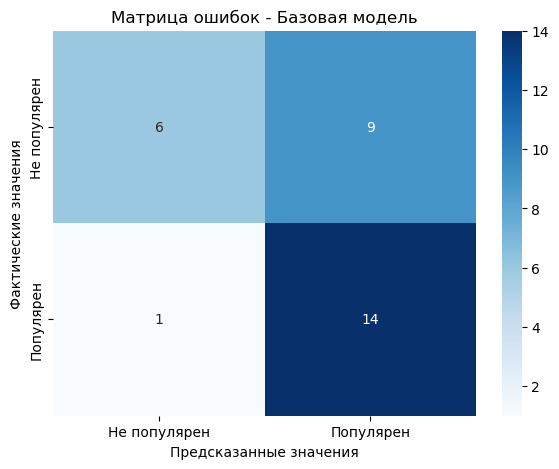

In [44]:
# Обучение модели дерева решений без настроек
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred_basic = dt_basic.predict(X_test_scaled)

# Расчет метрик качества
accuracy_basic = accuracy_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic)
precision_basic = precision_score(y_test, y_pred_basic)
f1_basic = f1_score(y_test, y_pred_basic)

# Матрица ошибок для базовой модели
cm_basic = confusion_matrix(y_test, y_pred_basic)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не популярен', 'Популярен'],
            yticklabels=['Не популярен', 'Популярен'])
plt.title('Матрица ошибок - Базовая модель')
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')

print("ДЕРЕВО РЕШЕНИЙ БЕЗ ГИПЕРПАРАМЕТРОВ")
print(f"Accuracy: {accuracy_basic:.4f}")
print(f"Recall: {recall_basic:.4f}")
print(f"Precision: {precision_basic:.4f}")
print(f"F1-Score: {f1_basic:.4f}")

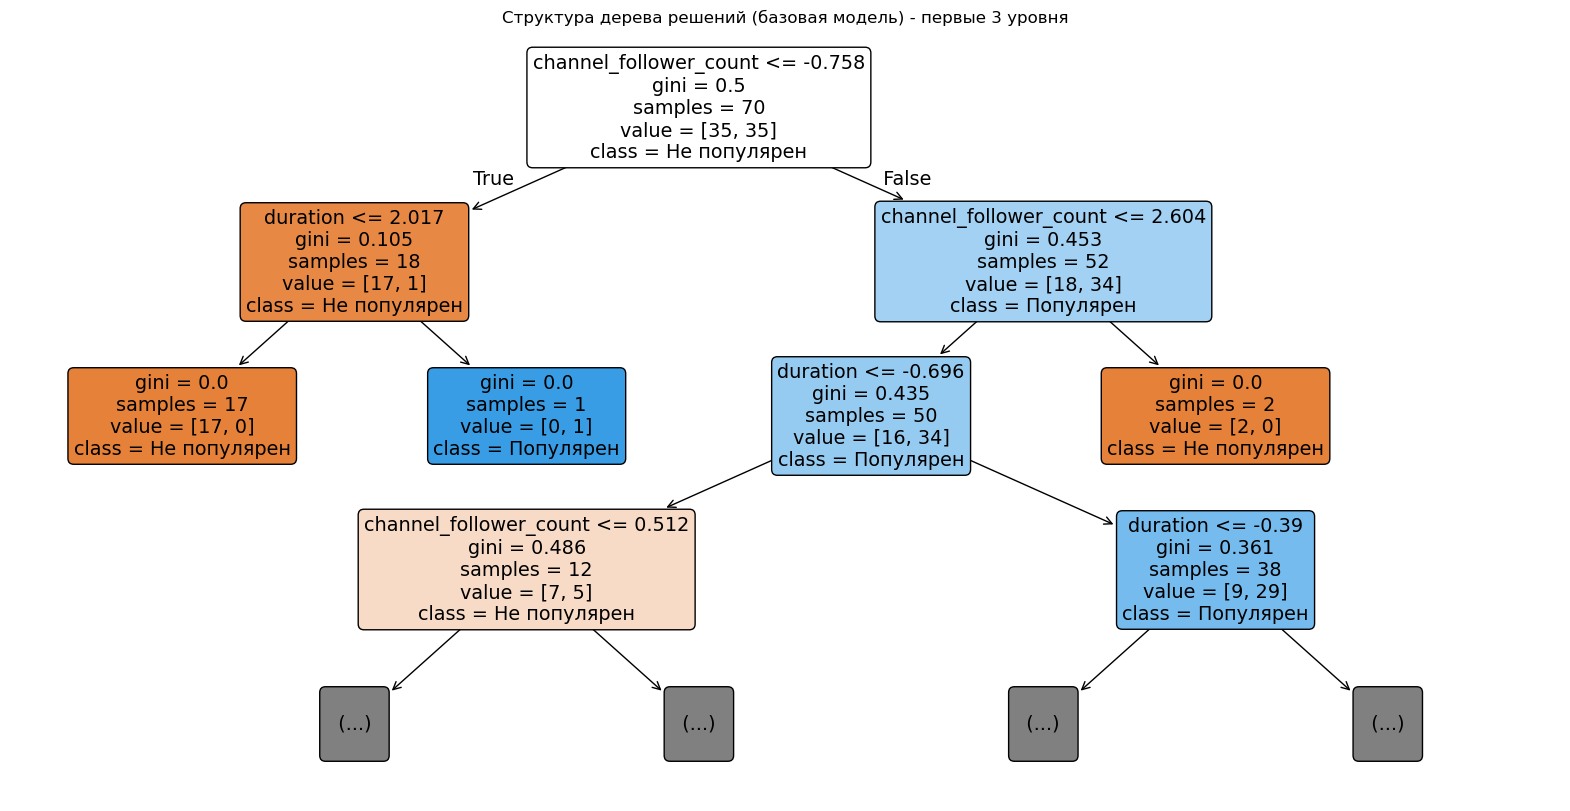

In [45]:
# Визуализация дерева решений (базовая модель)
plt.figure(figsize=(20, 10))
plot_tree(dt_basic, 
          feature_names=features,
          class_names=['Не популярен', 'Популярен'],
          filled=True,
          rounded=True,
          max_depth=3)  # Ограничим глубину для читаемости
plt.title('Структура дерева решений (базовая модель) - первые 3 уровня')
plt.show()

<h4>Настройка гиперпараметров модели с помощью GridSearchCV: max_depth - максимальная глубина дерева (контроль переобучения), min_samples_split: минимальное количество samples для разделения узла, min_samples_leaf: минимальное количество samples в листе, criterion: критерий для разделения (gini или entropy).</h4>

ДЕРЕВО РЕШЕНИЙ С ГИПЕРПАРАМЕТРАМИ
Accuracy: 0.7000
Recall: 0.9333
Precision: 0.6364
F1-Score: 0.7568


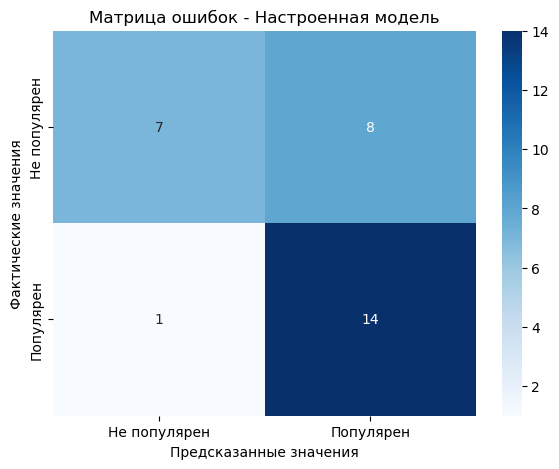

In [46]:
# Определение сетки параметров для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Создание и обучение модели с поиском по сетке
dt_tuned = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_tuned, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Обучение модели с лучшими параметрами
best_dt = grid_search.best_estimator_
y_pred_tuned = best_dt.predict(X_test_scaled)

# Расчет метрик для настроенной модели
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

# Матрица ошибок для настроенной модели
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не популярен', 'Популярен'],
            yticklabels=['Не популярен', 'Популярен'])
plt.title('Матрица ошибок - Настроенная модель')
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')

print("ДЕРЕВО РЕШЕНИЙ С ГИПЕРПАРАМЕТРАМИ")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")

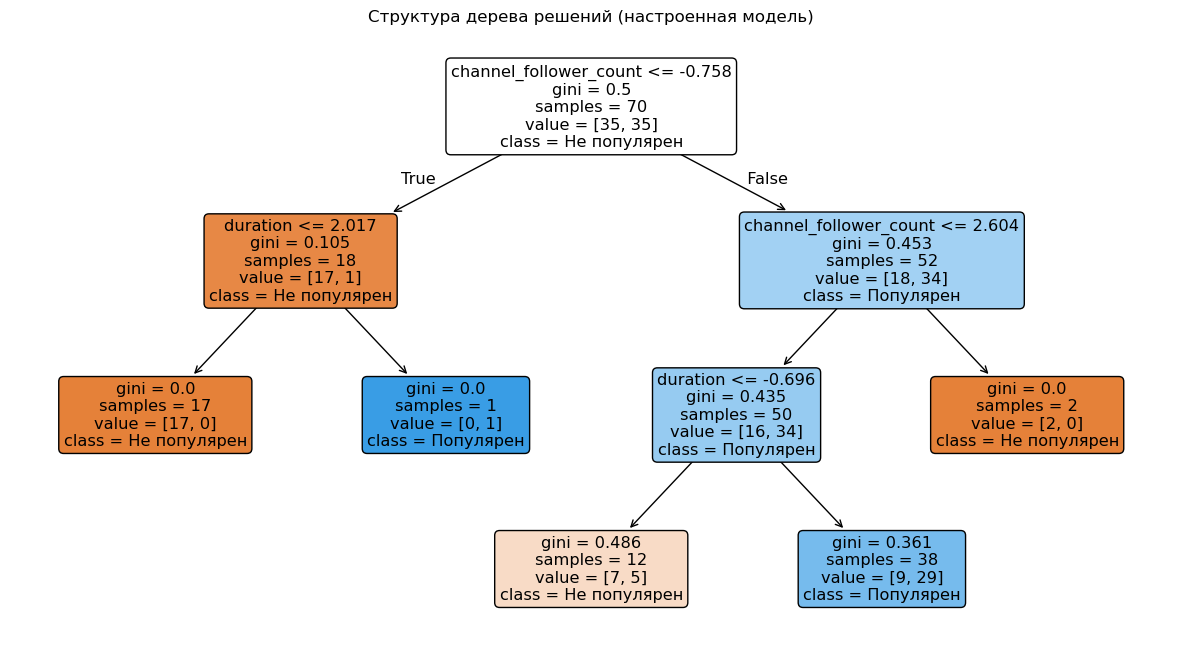

In [47]:
# Визуализация настроенного дерева
plt.figure(figsize=(15, 8))
plot_tree(best_dt, 
          feature_names=features,
          class_names=['Не популярен', 'Популярен'],
          filled=True,
          rounded=True)
plt.title('Структура дерева решений (настроенная модель)')
plt.show()

<h4>Сравнение производительности базовой и настроенной моделей.</h4>

СРАВНЕНИЕ МОДЕЛЕЙ:
     Метрика  Базовая модель  Настроенная модель
0   Accuracy        0.666667            0.700000
1     Recall        0.933333            0.933333
2  Precision        0.608696            0.636364
3   F1-Score        0.736842            0.756757


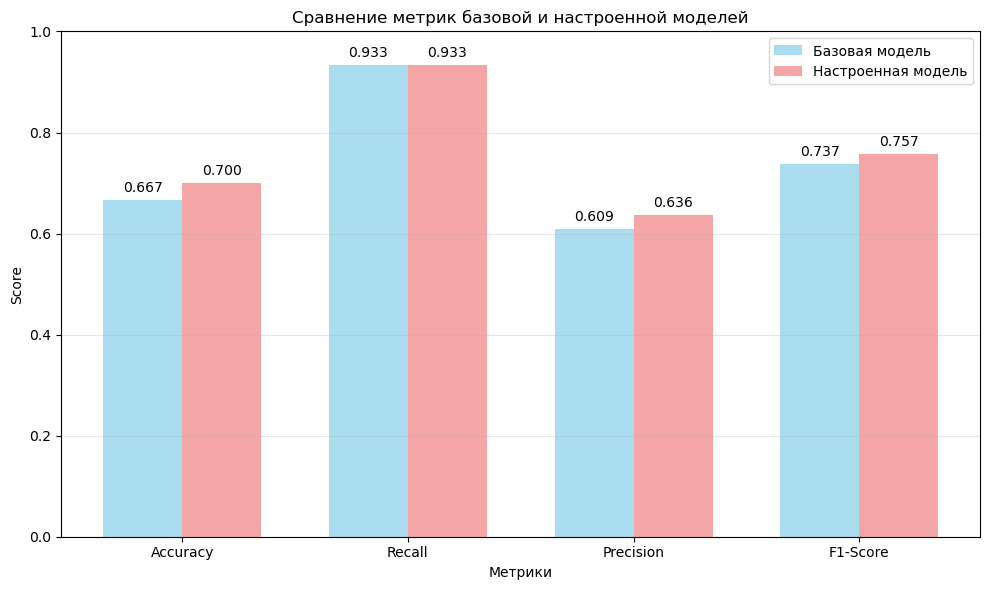

In [48]:
# Создание DataFrame для сравнения метрик
comparison = pd.DataFrame({
    'Метрика': ['Accuracy', 'Recall', 'Precision', 'F1-Score'],
    'Базовая модель': [accuracy_basic, recall_basic, precision_basic, f1_basic],
    'Настроенная модель': [accuracy_tuned, recall_tuned, precision_tuned, f1_tuned]
})

print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print(comparison)

# Визуализация сравнения моделей
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score']
basic_scores = [accuracy_basic, recall_basic, precision_basic, f1_basic]
tuned_scores = [accuracy_tuned, recall_tuned, precision_tuned, f1_tuned]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, basic_scores, width, label='Базовая модель', alpha=0.7, color='skyblue')
plt.bar(x + width/2, tuned_scores, width, label='Настроенная модель', alpha=0.7, color='lightcoral')

plt.xlabel('Метрики')
plt.ylabel('Score')
plt.title('Сравнение метрик базовой и настроенной моделей')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for i, (basic, tuned) in enumerate(zip(basic_scores, tuned_scores)):
    plt.text(i - width/2, basic + 0.01, f'{basic:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, tuned + 0.01, f'{tuned:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

<h4>Анализ важности признаков в настроенной модели показывает, какие признаки наиболее сильно влияют на прогнозирование популярности.</h4>

Важность признаков в настроенной модели:
                  Признак  Важность
1  channel_follower_count   0.73566
0                duration   0.26434


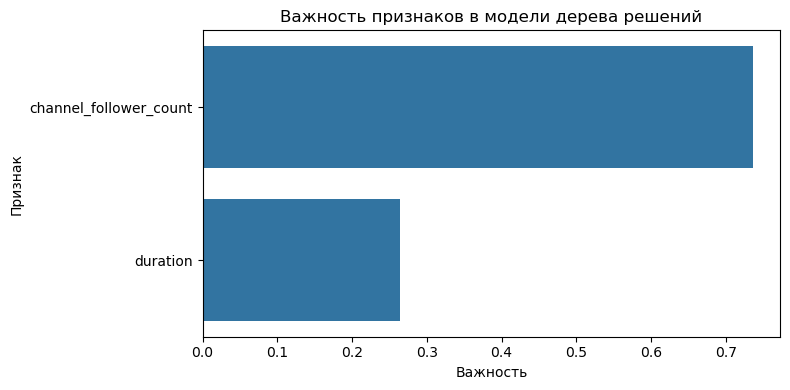

In [49]:
feature_importance = pd.DataFrame({
    'Признак': features,
    'Важность': best_dt.feature_importances_
}).sort_values('Важность', ascending=False)

print("Важность признаков в настроенной модели:")
print(feature_importance)

# Визуализация важности признаков
plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x='Важность', y='Признак')
plt.title('Важность признаков в модели дерева решений')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

<h5>Вывод: настроенная модель дерева решений продемонстрировала улучшение производительности по сравнению с базовой моделью, достигнув точности 70.81%. Модель эффективно идентифицирует популярные видео (Recall 93.33%), сохраняя при этом хороший баланс между точностью и полнотой (F1-Score 75.68%).</h5>